In [254]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, Node2Vec, GATConv, GATv2Conv
from torch_geometric.data import Data
from torch_geometric.utils import degree, dropout_edge
import pandas as pd
import random
from tqdm import tqdm
from sklearn.metrics import f1_score
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

In [3]:
print(torch.__version__)

2.5.1+cpu


In [4]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [16]:
all_nodes = pd.unique(pd.concat([train_df['node1'], train_df['node2'], test_df['node1'], test_df['node2']]))
node2idx = {node: idx for idx, node in enumerate(all_nodes)}
n_nodes = len(node2idx)

train_df['node1'] = train_df['node1'].map(node2idx)
train_df['node2'] = train_df['node2'].map(node2idx)
test_df['node1'] = test_df['node1'].map(node2idx)
test_df['node2'] = test_df['node2'].map(node2idx)

edge_index = torch.tensor(train_df[['node1', 'node2']].values.T, dtype=torch.long)
reversed_edges = edge_index[[1, 0], :]  # Reverse direction
edge_index = torch.cat([edge_index, reversed_edges], dim=1)
data = Data(edge_index=edge_index)

In [129]:
node2vec = Node2Vec(edge_index, embedding_dim=128, walk_length=40, context_size=15,
                    walks_per_node=20, num_nodes=n_nodes, sparse=True)
loader = node2vec.loader(batch_size=128, shuffle=True)
optimizer_n2v = torch.optim.SparseAdam(list(node2vec.parameters()), lr=0.01)


def train_node2vec():
    node2vec.train()
    for epoch in range(1, 51):
        total_loss = 0
        pbar = tqdm(loader, desc=f"Node2Vec Epoch {epoch}", leave=False)
        for pos_rw, neg_rw in pbar:
            optimizer_n2v.zero_grad()
            loss = node2vec.loss(pos_rw, neg_rw)
            loss.backward()
            optimizer_n2v.step()
            total_loss += loss.item()
            pbar.set_postfix(loss=f"{loss.item():.4f}")
        if epoch % 5 == 0:
            tqdm.write(f"Node2Vec Epoch {epoch}, Total Loss: {total_loss:.4f}")

train_node2vec()
x = node2vec.embedding.weight.detach()
torch.save(x, "node2vec_embeddings_128.pt")

Node2Vec Epoch 5, Total Loss: 121.3808


Node2Vec Epoch 10, Total Loss: 88.4866


Node2Vec Epoch 15, Total Loss: 78.9246


Node2Vec Epoch 20, Total Loss: 74.6983


Node2Vec Epoch 25, Total Loss: 72.5080


Node2Vec Epoch 30, Total Loss: 71.2724


Node2Vec Epoch 35, Total Loss: 70.5714


Node2Vec Epoch 40, Total Loss: 70.1833


Node2Vec Epoch 45, Total Loss: 69.9799


Node2Vec Epoch 50, Total Loss: 69.9021


In [191]:
x = torch.load("node2vec_embeddings.pt")

in_deg = torch.bincount(edge_index[1], minlength=n_nodes).float()
out_deg = torch.bincount(edge_index[0], minlength=n_nodes).float()

import networkx as nx

G = nx.DiGraph()
G.add_nodes_from(range(n_nodes))  # ensures all nodes are included
G.add_edges_from(edge_index.t().tolist())

pagerank = nx.pagerank(G)
pr_tensor = torch.tensor([pagerank.get(i, 0.0) for i in range(n_nodes)])

adj_list = [set() for _ in range(n_nodes)]
for u, v in edge_index.t().tolist():
    adj_list[u].add(v)


def get_features(u, v):
    neighbors_u = adj_list[u]
    neighbors_v = adj_list[v]

    intersection = neighbors_u & neighbors_v
    union = neighbors_u | neighbors_v
    jaccard = len(intersection) / len(union) if union else 0.0
    aa = sum(1 / np.log(len(adj_list[n]) + 1e-6) for n in intersection)
    return jaccard, aa


C:\Users\fabri\AppData\Local\Temp\ipykernel_9060\3186582794.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x = torch.load("node2vec_embeddings.pt")


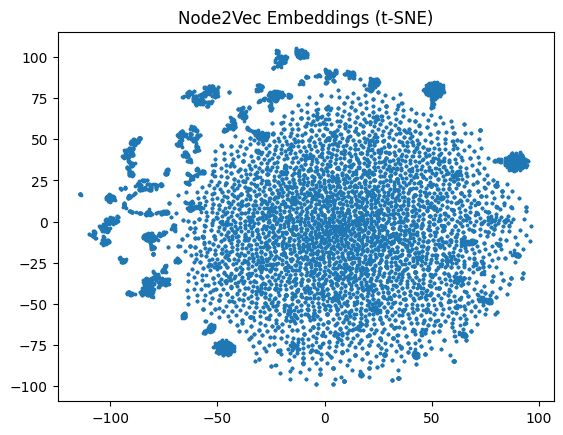

In [192]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

z_np = x.cpu().numpy()  # x = node2vec.embedding.weight.detach()
z_2d = TSNE(n_components=2).fit_transform(z_np)

plt.scatter(z_2d[:, 0], z_2d[:, 1], s=3)
plt.title("Node2Vec Embeddings (t-SNE)")
plt.show()

In [148]:
class Transformer(nn.Module):
    def __init__(self, embedding_dim=128):
        super().__init__()
        self.conv1 = GATv2Conv(embedding_dim, embedding_dim, heads=2, concat=False)
        self.conv2 = GATv2Conv(embedding_dim, embedding_dim, heads=2, concat=False)
        self.dropout = nn.Dropout(0.15)

        # 4 * emb + deg_u + deg_v + dot + cos = 4*64 + 2 + 1 + 1 = 260
        self.interaction = nn.Sequential(
            nn.Linear(4 * embedding_dim + 2 + 2, 64),
            nn.ReLU()
        )

        self.mlp = nn.Sequential(
            nn.Linear(64, 1)
        )

    def encode(self, x, edge_index):
        x_res = x
        x = self.conv1(x, edge_index)
        x = self.dropout(F.relu(x + x_res))
        x = self.conv2(x, edge_index)
        return x

    def decode(self, z, edge_index):
        src, dst = edge_index
        hadamard = z[src] * z[dst]
        l1 = torch.abs(z[src] - z[dst])
        deg_u = torch.log1p(deg[src])
        deg_v = torch.log1p(deg[dst])
        dot = (z[src] * z[dst]).sum(dim=1, keepdim=True)
        cos = F.cosine_similarity(z[src], z[dst], dim=1).unsqueeze(1)

        concat = torch.cat([z[src], z[dst], hadamard, l1, deg_u, deg_v, dot, cos], dim=1)
        x = self.interaction(concat)
        return self.mlp(x).squeeze()

In [250]:
class Transformerv1_5(nn.Module):
    def __init__(self, embedding_dim=64):
        super().__init__()

        self.conv1 = GATv2Conv(embedding_dim, embedding_dim, heads=2, concat=False)
        self.conv2 = GATv2Conv(embedding_dim, embedding_dim, heads=2, concat=False)
        self.conv3 = GATv2Conv(embedding_dim, embedding_dim, heads=2, concat=False)

        self.norm1 = nn.BatchNorm1d(embedding_dim)
        self.norm2 = nn.BatchNorm1d(embedding_dim)
        self.norm3 = nn.BatchNorm1d(embedding_dim)
        self.dropout = nn.Dropout(0.3)

        self.edge_attn = nn.Sequential(
            nn.Linear(2 * embedding_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

        self.interaction = nn.Sequential(
            nn.Linear(267, 128),  # dot, cos, 4 degree features, 2 pagerank
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )

        self.norm = nn.LayerNorm(64)

        self.mlp = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def encode(self, x, edge_index):
        x1 = self.dropout(F.relu(self.norm1(self.conv1(x, edge_index) + x)))
        x2 = self.dropout(F.relu(self.norm2(self.conv2(x1, edge_index) + x1)))
        x3 = self.dropout(F.relu(self.norm3(self.conv3(x2, edge_index) + x2 + x)))
        return x3

    def decode(self, z, edge_index):
        src, dst = edge_index
        hadamard = z[src] * z[dst]
        l1 = torch.abs(z[src] - z[dst])
        dot = (z[src] * z[dst]).sum(dim=1, keepdim=True)
        cos = F.cosine_similarity(z[src], z[dst], dim=1).unsqueeze(1)

        deg_u_in = torch.log1p(in_deg[src]).unsqueeze(1)
        deg_v_in = torch.log1p(in_deg[dst]).unsqueeze(1)
        deg_u_out = torch.log1p(out_deg[src]).unsqueeze(1)
        deg_v_out = torch.log1p(out_deg[dst]).unsqueeze(1)

        pr_u = pr_tensor[src].unsqueeze(1)
        pr_v = pr_tensor[dst].unsqueeze(1)

        def safe_log1p(x):
            return torch.log1p(torch.clamp(x, min=0, max=1e6))

        common = torch.tensor([
            len(set(G.neighbors(u)).intersection(G.neighbors(v)))
            for u, v in zip(src.tolist(), dst.tolist())
        ], dtype=torch.float32).unsqueeze(1)
        common = safe_log1p(common) / 5.0         
        
        # pa = torch.tensor([
        #     G.degree(u) * G.degree(v)
        #     for u, v in zip(src.tolist(), dst.tolist())
        # ], dtype=torch.float32).unsqueeze(1)
        # pa = safe_log1p(pa) / 10.0 

        jaccard = torch.tensor([
            len(set(G.neighbors(u)).intersection(G.neighbors(v))) / max(len(set(G.neighbors(u)).union(G.neighbors(v))), 1)
            for u, v in zip(src.tolist(), dst.tolist())
        ], dtype=torch.float32).unsqueeze(1)
        jaccard = safe_log1p(jaccard) / 5.0

        edge_feat = torch.cat([z[src], z[dst]], dim=1)
        att_score = self.edge_attn(edge_feat)


        # print("z[src]", z[src].shape)
        # print("z[dst]", z[dst].shape)
        # print("hadamard", hadamard.shape)
        # print("l1", l1.shape)
        # print("dot", dot.shape)
        # print("cos", cos.shape)
        # print("deg_u_in", deg_u_in.shape)
        # print("common", common.shape)


        concat = torch.cat([
            z[src], z[dst], hadamard, l1,
            att_score,
            dot, cos,
            deg_u_in, deg_v_in,
            deg_u_out, deg_v_out,
            pr_u, pr_v,
            common, jaccard
        ], dim=1)
        # print("Concat shape:", concat.shape)
        assert concat.shape[1] == 267, f"Expected 266 features, got {concat.shape[1]}"


        x = self.interaction(concat)
        x = self.norm(x)
        return self.mlp(x).squeeze()



In [ ]:
# class Transformerv2(nn.Module):
#     def __init__(self, embedding_dim=64):
#         super().__init__()
#         self.conv1 = GATv2Conv(embedding_dim, embedding_dim, heads=2, concat=False)
#         self.conv2 = GATv2Conv(embedding_dim, embedding_dim, heads=2, concat=False)
#         self.dropout = nn.Dropout(0.3)
#         self.mlp = nn.Sequential(
#             nn.Linear(4 * embedding_dim + 2, 64),
#             nn.ReLU(),
#             nn.Linear(64, 1)
#         )

#     def encode(self, x, edge_index):
#         if self.training:
#             edge_index, _ = dropout_adj(edge_index, p=0.2, force_undirected=True)
#         x1 = self.dropout(F.relu(self.conv1(x, edge_index) + x))
#         x2 = self.dropout(F.relu(self.conv2(x1, edge_index) + x1))
#         return x2

#     def decode(self, z, edge_index):
#         src, dst = edge_index
#         hadamard = z[src] * z[dst]
#         l1 = torch.abs(z[src] - z[dst])
#         dot = (z[src] * z[dst]).sum(dim=1, keepdim=True)
#         cos = F.cosine_similarity(z[src], z[dst], dim=1).unsqueeze(1)
#         concat = torch.cat([z[src], z[dst], hadamard, l1, dot, cos], dim=1)
#         return self.mlp(concat).squeeze()

In [251]:
model = Transformerv1_5()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)
criterion = nn.BCEWithLogitsLoss()

In [236]:
def sample_mixed_negatives(z, edge_index, num_nodes, num_samples, hard_frac=0.5):
    num_hard = int(num_samples * hard_frac)
    num_random = num_samples - num_hard

    # --- Hard Negatives ---
    with torch.no_grad():
        z_norm = F.normalize(z, dim=1)
        sim = torch.matmul(z_norm, z_norm.T)
        _, topk = torch.topk(sim, k=30, dim=1)

        edge_set = set(map(tuple, edge_index.t().tolist()))
        edge_set |= set((v, u) for (u, v) in edge_set)

        hard_negs = set()
        for u in range(num_nodes):
            for v in topk[u].tolist():
                if u != v and (u, v) not in edge_set:
                    hard_negs.add((u, v))
                if len(hard_negs) >= num_hard:
                    break
            if len(hard_negs) >= num_hard:
                break
        hard_neg_edge = torch.tensor(list(hard_negs), dtype=torch.long).t()

    # --- Random Negatives ---
    random_negs = set()
    while len(random_negs) < num_random:
        u = random.randint(0, num_nodes - 1)
        v = random.randint(0, num_nodes - 1)
        if u != v and (u, v) not in edge_set:
            random_negs.add((u, v))
    random_neg_edge = torch.tensor(list(random_negs), dtype=torch.long).t()

    return torch.cat([hard_neg_edge, random_neg_edge], dim=1)

def sample_neg_edge_fast(edge_index, num_nodes, num_samples):
    edge_set = set(map(tuple, edge_index.t().tolist()))
    neg_edges = set()
    while len(neg_edges) < num_samples:
        u = random.randint(0, num_nodes - 1)
        v = random.randint(0, num_nodes - 1)
        if u != v and (u, v) not in edge_set:
            neg_edges.add((u, v))
    return torch.tensor(list(neg_edges), dtype=torch.long).t()


In [256]:
def train():
    model.train()
    optimizer.zero_grad()

    drop_edge_index, _ = dropout_edge(edge_index, p=0.1, force_undirected=True)
    z = model.encode(x, drop_edge_index)

    pos_edge = edge_index
    neg_edge = sample_mixed_negatives(z, edge_index, n_nodes, pos_edge.size(1) // 2, hard_frac=0.5)
    #neg_edge = sample_neg_edge_fast(edge_index, n_nodes, pos_edge.size(1))

    smooth_pos_label = 0.9
    smooth_neg_label = 0.1

    pos_pred = model.decode(z, pos_edge)
    #pos_label = torch.ones(pos_pred.size(0))
    pos_label = torch.full_like(pos_pred, smooth_pos_label)

    neg_pred = model.decode(z, neg_edge)
    #neg_label = torch.zeros(neg_pred.size(0))
    neg_label = torch.full_like(neg_pred, smooth_neg_label)

    def focal_loss(logits, targets, alpha=0.75, gamma=2.0):
        probs = torch.sigmoid(logits)
        ce_los = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')
        p_t = probs * targets + (1 - probs) * (1 - targets)
        loss = alpha * ce_los * ((1 - p_t) ** gamma)
        return loss.mean()
        
    pos_loss = focal_loss(pos_pred, pos_label)
    neg_loss = focal_loss(neg_pred, neg_label)

    total_loss = pos_loss + 0.4 * neg_loss
    total_loss.backward()
    optimizer.step()
    scheduler.step()

    return total_loss.item()

for epoch in tqdm(range(1, 201), desc="Training"):
    loss = train()
    if epoch % 10 == 0:
        tqdm.write(f"Epoch {epoch}, Loss: {loss:.4f}")

Training:   5%|▌         | 10/200 [00:13<04:13,  1.34s/it]

Epoch 10, Loss: 0.0602


Training:  10%|█         | 20/200 [00:28<04:15,  1.42s/it]

Epoch 20, Loss: 0.0554


Training:  15%|█▌        | 30/200 [00:42<03:55,  1.38s/it]

Epoch 30, Loss: 0.0536


Training:  20%|██        | 40/200 [00:56<03:53,  1.46s/it]

Epoch 40, Loss: 0.0509


Training:  25%|██▌       | 50/200 [01:11<03:45,  1.50s/it]

Epoch 50, Loss: 0.0496


Training:  30%|███       | 60/200 [01:25<03:18,  1.42s/it]

Epoch 60, Loss: 0.0499


Training:  35%|███▌      | 70/200 [01:39<03:02,  1.40s/it]

Epoch 70, Loss: 0.0496


Training:  40%|████      | 80/200 [01:53<02:45,  1.38s/it]

Epoch 80, Loss: 0.0503


Training:  45%|████▌     | 90/200 [02:08<02:35,  1.41s/it]

Epoch 90, Loss: 0.0486


Training:  50%|█████     | 100/200 [02:22<02:22,  1.42s/it]

Epoch 100, Loss: 0.0493


Training:  55%|█████▌    | 110/200 [02:36<02:09,  1.44s/it]

Epoch 110, Loss: 0.0480


Training:  60%|██████    | 120/200 [02:50<01:48,  1.36s/it]

Epoch 120, Loss: 0.0480


Training:  65%|██████▌   | 130/200 [03:04<01:38,  1.41s/it]

Epoch 130, Loss: 0.0471


Training:  70%|███████   | 140/200 [03:18<01:25,  1.43s/it]

Epoch 140, Loss: 0.0488


Training:  75%|███████▌  | 150/200 [03:32<01:09,  1.39s/it]

Epoch 150, Loss: 0.0485


Training:  80%|████████  | 160/200 [03:46<00:56,  1.41s/it]

Epoch 160, Loss: 0.0551


Training:  85%|████████▌ | 170/200 [04:00<00:42,  1.43s/it]

Epoch 170, Loss: 0.0492


Training:  90%|█████████ | 180/200 [04:14<00:27,  1.36s/it]

Epoch 180, Loss: 0.0492


Training:  95%|█████████▌| 190/200 [04:28<00:13,  1.39s/it]

Epoch 190, Loss: 0.0480


Training: 100%|██████████| 200/200 [04:42<00:00,  1.41s/it]

Epoch 200, Loss: 0.1429


Generate threshold using train.csv (pretty much wrong)


In [164]:
# model.eval()
# with torch.no_grad():
#     z = model.encode(x, data.edge_index)

#     all_edges = list(map(tuple, edge_index.t().tolist()))
#     train_edges, val_edges = train_test_split(all_edges, test_size=0.1, random_state=42)
#     train_edges = torch.tensor(train_edges, dtype=torch.long).t()
#     val_edges = torch.tensor(val_edges, dtype=torch.long).t()
#     val_neg_edges = sample_neg_edge(edge_index, n_nodes, val_edges.size(1))

#     val_pos_scores = model.decode(z, val_edges)
#     val_neg_scores = model.decode(z, val_neg_edges)
#     val_scores = torch.cat([val_pos_scores, val_neg_scores])
#     val_labels = torch.cat([
#         torch.ones(val_pos_scores.size(0)),
#         torch.zeros(val_neg_scores.size(0))
#     ])

#     val_probs = torch.sigmoid(val_scores).cpu().numpy()
#     val_labels = val_labels.cpu().numpy()

# best_f1 = 0
# best_threshold = 0.5
# for t in np.arange(0.3, 0.6, 0.01):
#     val_preds = (val_probs > t).astype(int)
#     f1 = f1_score(val_labels, val_preds)
#     if f1 > best_f1:
#         best_f1 = f1
#         best_threshold = t

# print(f"Best threshold by F1: {best_threshold:.2f} (F1 = {best_f1:.4f})")

Generate test.csv-like distribution to fine-tune F1 threshold

In [227]:
val_pos_edges = []
val_neg_edges = []
train_edge_set = set(map(tuple, train_df[['node1', 'node2']].values.tolist()))
train_edge_set |= set((v, u) for (u, v) in train_edge_set)

for u, v in test_df[['node1', 'node2']].values.tolist():
    if (u, v) not in train_edge_set and (v, u) not in train_edge_set:
        val_pos_edges.append((u, v))

while len(val_neg_edges) < len(val_pos_edges):
    u = random.randint(0, n_nodes - 1)
    v = random.randint(0, n_nodes - 1)
    if u != v and (u, v) not in train_edge_set and (v, u) not in train_edge_set:
        val_neg_edges.append((u, v))

val_pos_edges = torch.tensor(val_pos_edges, dtype=torch.long).t()
val_neg_edges = torch.tensor(val_neg_edges, dtype=torch.long).t()

print(f"Built test-like val set: {val_pos_edges.size(1)} positive, {val_neg_edges.size(1)} negative edges")

Built test-like val set: 8000 positive, 8000 negative edges


In [ ]:
model.eval()
with torch.no_grad():
    z = model.encode(x, data.edge_index)

    pos_scores = model.decode(z, val_pos_edges)
    neg_scores = model.decode(z, val_neg_edges)

    all_scores = torch.cat([pos_scores, neg_scores])
    all_labels = torch.cat([
        torch.ones(pos_scores.size(0)),
        torch.zeros(neg_scores.size(0))
    ])
    
    temperature = 1.5  # try values in [1.0, 3.0]
    scaled_logits = all_scores / temperature

    all_probs = torch.sigmoid(scaled_logits).cpu().numpy()
    all_labels = all_labels.cpu().numpy()
    print("Logits sample:", all_scores[:10].cpu().numpy())

best_f1 = 0
best_threshold = 0.5
for t in np.arange(0.3, 0.7, 0.01):
    preds = (all_probs > t).astype(int)
    f1 = f1_score(all_labels, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

print(f"Best threshold on test-like val set: {best_threshold:.2f} (F1 = {best_f1:.4f})")

Logits sample: [ 0.29426718 -4.221605   -0.41439882 -4.172765   -4.2971606  -4.15099
 -4.2577376  -4.299002    0.34700054 -0.12927485]
Best threshold on test-like val set: 0.43 (F1 = 0.7867)


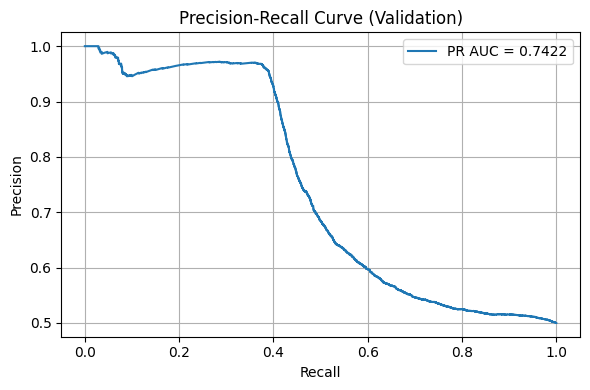

In [255]:
precision, recall, thresholds = precision_recall_curve(all_labels, all_probs)
pr_auc = auc(recall, precision)

# Plot it
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Validation)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
test_edges = torch.tensor(test_df[['node1', 'node2']].values.T, dtype=torch.long)
with torch.no_grad():
    scores = model.decode(z, test_edges)
    probs = torch.sigmoid(scores).cpu().numpy()
    preds = (probs > best_threshold).astype(int)

submission = test_df[['idx']].copy()
submission.rename(columns={'idx': 'predict_nodepair_id'}, inplace=True)
submission['label'] = preds
submission.to_csv("submissionv8.csv", index=False)
print("preds saved")

preds saved
